<a href="https://colab.research.google.com/github/ajaynain-eng/Hyperspectral-Image-Classification/blob/main/MLP/MLP-Mixer/mp-mixer%20on%20372_bands%20dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Copy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title  { display-mode: "form" }
#@title  { display-mode: "form" }
#@title  { vertical-output: true, display-mode: "form" }
#@markdown Select the best

def str_to_bool(x):
    return True if x == "True" else False

use_pearson_corr = "False"  #@param ["True", "False"]
patch_method = "extract"    #@param ["extract", "conv"]

H, W, B = 1101, 566, 372               # height,width and band of image
P_S = 9                             #@param [3, 9, 15, 21]                         
patch_size = 3                      # Size of the patches to be extract from the input images
# valid patch size is that number which is divisible by 3 i.e. 3,6,9,12

train_percent = 75          #@param [75, 80, 90]
epoch = 300               #@param [100, 200, 300, 400]

LR_START = 3e-3
LR_MAX = 6e-3 
LR_MIN = 1e-5

batch_size = 128
BATCH_SIZE = 128
dropout = 0.2
num_patches = (P_S//patch_size)**2

num_layers = 4              #@param [1,2,3,4,5,6,7]
projection_dim = 256        #@param [64, 128, 256, 512, 1024]
tokens_mlp_dim = 64         #@param [32, 64, 128, 256]
dropout_ratio = 0.0         #@param ["0.0", "0.1", "0.2", "0.3", "0.4", "0.5"]

use_pearson_corr = str_to_bool(use_pearson_corr)
P_S = int(P_S)
train_percent = int(train_percent)
epoch = int(epoch)
tokens_mlp_dim = int(tokens_mlp_dim) 
channels_mlp_dim = tokens_mlp_dim
projection_dim = int(projection_dim)
dropout_ratio = float(dropout_ratio)
num_layers = int(num_layers)

print("Number of patches per P_S: ", num_patches)
print("Size of each patch for MLP Mixture: ", patch_size)

Number of patches per P_S:  9
Size of each patch for MLP Mixture:  3


In [ ]:
!pip install spectral

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 KB 13.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd           # for csv files and dataframes
import numpy as np            # Linear Algebra tools
import matplotlib.pyplot as plt  # for ploting graphs and curve
from matplotlib import colors, cm, gridspec
import scipy.stats as st
import scipy.io as si         # for inputing matlab files
from random import shuffle    # for shuffling dataset
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix   #Confusion matrix creation
from sklearn.metrics import accuracy_score, cohen_kappa_score
from sklearn.metrics import classification_report

import datetime
import time
import warnings
import math
import os
import gc
import pickle

import tensorflow as tf
# import tensorflow_addons as tfa
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import Sequential, layers
from tensorflow.keras import activations
from tensorflow.keras.layers import Input,Add,Multiply, Reshape, Dense, Activation, BatchNormalization, Flatten, Dropout, concatenate,LayerNormalization
from tensorflow.keras.layers import Conv2D, AveragePooling2D, MaxPooling2D,  GlobalAveragePooling1D, GlobalAvgPool2D, DepthwiseConv2D, SeparableConv2D
from tensorflow.keras.layers import Conv2DTranspose, add, multiply, Layer, MaxPool2D, UpSampling2D, Lambda, Permute
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model, Model
from tensorflow.keras import optimizers
from tensorflow.keras.initializers import glorot_uniform, Ones
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from keras.regularizers import l2

import spectral
from imgaug import augmenters as iaa
import imgaug as ia
tfds.disable_progress_bar()
tf.random.set_seed(42)
ia.seed(42)

AUTO = tf.data.AUTOTUNE
np.random.seed(1337)          # to get reproducible results
if use_pearson_corr:
    folder_path = "/content/drive/MyDrive/m_p/MLP/MLP-mixer/372 bands/With Pearson correlation/"
else:
    folder_path = "/content/drive/MyDrive/m_p/MLP/MLP-mixer/372 bands/Without Pearson correlation/"

In [ ]:
mat_x = si.loadmat('/content/drive/My Drive/m_p/data/372 band/full.mat')['full']           # shape 623166*372
mat_y = si.loadmat('/content/drive/My Drive/m_p/data/372 band/full_gt.mat')['full_gt']     # shape 623166*1
# selective_bands = [0, 53, 56, 70, 71, 103, 106, 113, 115, 116, 117, 142, 174, 188, 195, 198, 200, 201, 203, 205, 207, 238, 239, 254, 264, 266, 272, 274, 281, 282, 
#                    284, 285, 292, 293, 296, 298, 301, 303, 310, 313, 315, 337, 341, 342, 343, 345, 346, 349, 369]

mat_x[mat_x < 0.0] = 0.0
mat_x[mat_x > 1.0] = 1.0
print("minimum value in mat_x is :", mat_x.min())
print("maximum value in mat_x is :", mat_x.max())
# mat_x = mat_x[:, selective_bands]
x, y = np.array(mat_x), np.array(mat_y)
x, y = x.reshape(H,W,B), y.reshape(H,W)


x = x.astype('float16')

pad_width = int((P_S-1)/2)
padded_x = np.pad(x,[(pad_width,pad_width),(pad_width,pad_width),(0,0)],'edge')
# np.save("/content/drive/MyDrive/Personal Folder for training/padded_x.npy" , padded_x)
X,Y = [],[]
for a in range(H):
  for b in range(W):
    if(y[a][b]!= 0):
      patch = padded_x[a:a+P_S,b:b+P_S,:]
      X.append(patch)
      Y.append(y[a][b]-1)

num_classes = len(np.unique(y))-1


print("shape of mat_x: ", mat_x.shape)
print("shape of mat_y: ", mat_y.shape)
print()
print("minimum value in x is :", x.min())
print("maximum value in x is :", x.max())
print()
print("shape of x: ", x.shape)
print("shape of y: ", y.shape)
print()
print("shape of padded_x: ", padded_x.shape)
print()
print(f"{len(Y)*100/np.array(mat_y).shape[0]}% of data is labeled with {num_classes} classes")

minimum value in mat_x is : 0.0
maximum value in mat_x is : 1.0
shape of mat_x:  (623166, 372)
shape of mat_y:  (623166, 1)

minimum value in x is : 0.0
maximum value in x is : 1.0

shape of x:  (1101, 566, 372)
shape of y:  (1101, 566)

shape of padded_x:  (1109, 574, 372)

1.2595359823867156% of data is labeled with 13 classes


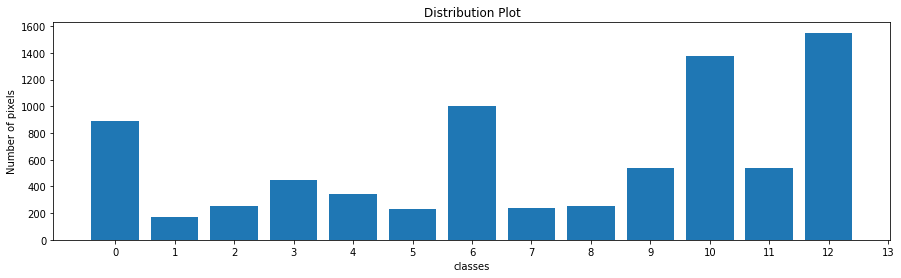

In [ ]:
class_labels, value_counts = np.unique(mat_y, return_counts = True)
plt.figure(figsize = (15,4))
plt.bar(class_labels[1:]-1, value_counts[1:])
plt.xticks(class_labels, rotation = 0)
plt.xlabel("classes")
plt.ylabel("Number of pixels")
plt.title("Distribution Plot")
plt.show()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=(train_percent/100),stratify=Y, random_state=10)
x_train, x_test,y_train,y_test = tf.cast(np.array(x_train), tf.float32), tf.cast(np.array(x_test), tf.float32), np.array(y_train), np.array(y_test)
print(f"x_train: {x_train.shape} \nx_test: {x_test.shape} \ny_train: {y_train.shape} \ny_test: {y_test.shape}")

x_train: (5886, 9, 9, 372) 
x_test: (1963, 9, 9, 372) 
y_train: (5886,) 
y_test: (1963,)


### Prediction and performance measure functions

In [ ]:
def predict_half_image(model, padded_x, H, W_range, B, P_S):
    y_hat = np.zeros((H,W_range))
    for j in range(W_range):
        patchs = np.zeros((H, P_S, P_S, B))
        for i in range(H):
            patchs[i,:,:,:] = padded_x[i:i+P_S, j:j+P_S, :]
        y_pred = model.predict(patchs)
        y_pred = np.argmax(y_pred,axis=1)+1
        y_hat[:,j] = y_pred
        del patchs
        gc.collect()
    return y_hat

def predict_image(model, padded_x, H, W, B, P_S):
    start_time = time.time()
    half_1 = padded_x.shape[1]//2 + pad_width+1
    half_2 = padded_x.shape[1]//2 - pad_width-1
    padded_x_1st_half = padded_x[:,:half_1, :]
    padded_x_2nd_half = padded_x[:,half_2:, :]
    del padded_x
    gc.collect()

    y_hat = np.zeros((H,W))
    y_hat[:,:W//2] = predict_half_image(model, padded_x_1st_half, H, W//2, B, P_S)
    # del padded_x_1st_half
    print("image predicted ███████████████████████ 50%")
    gc.collect()
    y_hat[:,W//2:] = predict_half_image(model, padded_x_2nd_half, H, W//2, B, P_S)
    # del padded_x_2nd_half
    print("image predicted ██████████████████████████████████████████████ 100%")
    gc.collect()
    end_time = time.time()
    time_taken = end_time - start_time
    time_min = time_taken//60
    time_sec = time_taken - time_min*60
    print(f'total time taken is: {time_min} min {time_sec} sec.')
    y_hat = np.reshape(y_hat, (H,W))
    print("shape of predicted image is: ", y_hat.shape)
    return y_hat

In [ ]:
def predict(model, x_test):
    y_pred = model.predict(x_test)
    y_pred1 = np.zeros((y_pred.shape[0],1))
    for a in range(y_pred.shape[0]):
        y_pred1[a] = np.argmax(y_pred[a])
    y_pred = y_pred1
    del y_pred1
    return y_pred

In [ ]:
def plot_accuracy_loss_curve(history, use_pearson_corr = None, folder_path = None):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    fig = plt.figure(figsize = (24,8))
    ax = plt.subplot(1,1,1)
    ax2 = ax.twinx()
    ax.plot(train_accuracy, color='blue', marker='o', linewidth=1.5, markersize = 2,  label = 'train_accuracy')
    ax.plot(val_accuracy, color='green', marker='o', linewidth=1.5, markersize = 2, label = 'val_accuracy')
    ax.grid()
    plt.xlabel('no. of epoches')
    plt.ylabel('accuracy')
    ax.legend()
    ax2.plot(train_loss, color = 'black', marker='o', linewidth=1.5, markersize = 2, label = 'train_loss')
    ax2.plot(val_loss, color = 'red', marker='o', linewidth=1.5, markersize = 2, label = 'val_loss')
    ax2.grid()
    plt.xlabel('no. of epoches')
    plt.ylabel('loss')
    plt.title('accuracy and loss plot for model performance')
    ax2.legend()
    plt.show()
    if folder_path:
        try:
            os.mkdir(folder_path + "Results/")
        except:
            pass
        if use_pearson_corr:
            path = folder_path + "Results/Pearson_Corr " + str(train_percent) + "% ps_"+ str(P_S) + " accuracy_loss.png"
        else:
            path = folder_path + "Results/" + str(train_percent) + "% ps_"+ str(P_S) + " accuracy_loss.png"
        fig.savefig(path)

In [ ]:
def performance_meausures(y_test, y_pred, tt, *parameters_summary, use_pearson_corr = None, folder_path = None):
    Total_params, Trainable_params, Non_trainable_params = parameters_summary
    accuracy = accuracy_score(y_test, y_pred)
    kappa=cohen_kappa_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred).astype('int32')
    cr = classification_report(y_test, y_pred, output_dict=True)
    df_cr = pd.DataFrame(cr).T
    df_score = pd.DataFrame({'accuracy score: ' : [accuracy], 'Cohen_Kappa score: ' : [kappa], "Training Time: " : [tt]}).T
    df_summary = pd.DataFrame({'Total_params: ': [Total_params], 'Trainable_params: ' : [Trainable_params], 'Non_trainable_params: ':[Non_trainable_params]}).T

    spec = gridspec.GridSpec(ncols = 2, nrows = 2, width_ratios=[1,3], wspace = 0.5, hspace = 0.5, height_ratios=[7,1])
    
    fig = plt.figure(figsize = (24,10))

    ax1 = fig.add_subplot(spec[0])
    ax1.set_title('classification report')
    sns.heatmap(df_cr, cmap = 'Blues', cbar = False, annot = True, fmt=' .5g', ax = ax1)

    ax2 = fig.add_subplot(spec[1])
    ax2.set_title('confusion matrix')
    ax2.set_xlabel('predicted class')
    ax2.set_ylabel('actual class')
    sns.heatmap(cm, cmap = 'Blues', cbar = False, annot = True, fmt=' .5g', ax = ax2)

    ax3 = fig.add_subplot(spec[2])
    sns.heatmap(df_score, cmap = 'Blues', cbar = False, annot = True, fmt=' .5g', ax = ax3)

    ax4 = fig.add_subplot(spec[3])
    sns.heatmap(df_summary, cmap = "Blues", cbar = False, annot = True, fmt=' .10g', ax = ax4)

    try:
        os.mkdir(folder_path + "Results/" )
    except:
        pass

    if folder_path:
        if use_pearson_corr:
            path = folder_path + "Results/" + str(train_percent) + "% ps_" + str(P_S) +" Performance Measure" + ".png"
        else:
            path = folder_path + "Results/" + str(train_percent) + "% ps_" + str(P_S)+ " Performance Measure" + ".png"
        fig.savefig(path)

### Building the classes and function for model

In [ ]:
class Pearson_correlation_masked(layers.Layer):
    def __init__(self, P_S = 9, **kwargs):
        super(Pearson_correlation_masked, self).__init__(**kwargs)
        self.P_S = P_S
    
    def call(self, inputs):
        self.loc = (self.P_S)//2
        self.inputs = inputs
        self.channels = self.inputs.shape[-1]
        self.x_mean = tf.repeat(tf.math.reduce_mean(self.inputs, axis = -1, keepdims=True), repeats = self.channels, axis = -1)

        self.y = tf.repeat(tf.repeat(self.inputs[:,self.loc:self.loc+1, self.loc:self.loc+1, :], repeats = self.P_S, axis = -2), repeats = self.P_S, axis = -3)

        self.y_mean = tf.repeat(tf.math.reduce_mean(self.y, axis = -1, keepdims = True), repeats = self.channels, axis = -1)

        self.a = tf.math.subtract(self.inputs, self.x_mean)
        self.b = tf.math.subtract(self.y, self.y_mean)
        self.ab = tf.math.multiply(self.a,self.b)
        self.num = tf.math.reduce_sum(self.ab, axis = -1, keepdims = True)

        self.a_new = tf.math.reduce_sum(tf.math.multiply(self.a, self.a), axis = -1, keepdims = True)
        self.b_new = tf.math.reduce_sum(tf.math.multiply(self.b, self.b), axis = -1, keepdims = True)
        self.deno = tf.math.sqrt(tf.math.multiply(self.a_new, self.b_new))
    
        self.corr = tf.math.divide(self.num, self.deno)

        self.thresh = tf.math.reduce_mean(self.corr)
        self.mask = self.corr > self.thresh
        self.mask = tf.cast(self.mask, self.corr.dtype)

        self.masked_corr = tf.math.multiply(self.mask, self.corr)
    
        self.attention_weights = tf.repeat(self.masked_corr, repeats = self.channels, axis = -1)
        return multiply([self.inputs, self.attention_weights])

    def get_config(self, **kwargs):
        config = super().get_config()
        config.update({
            "P_S": self.P_S,
        })
        return config

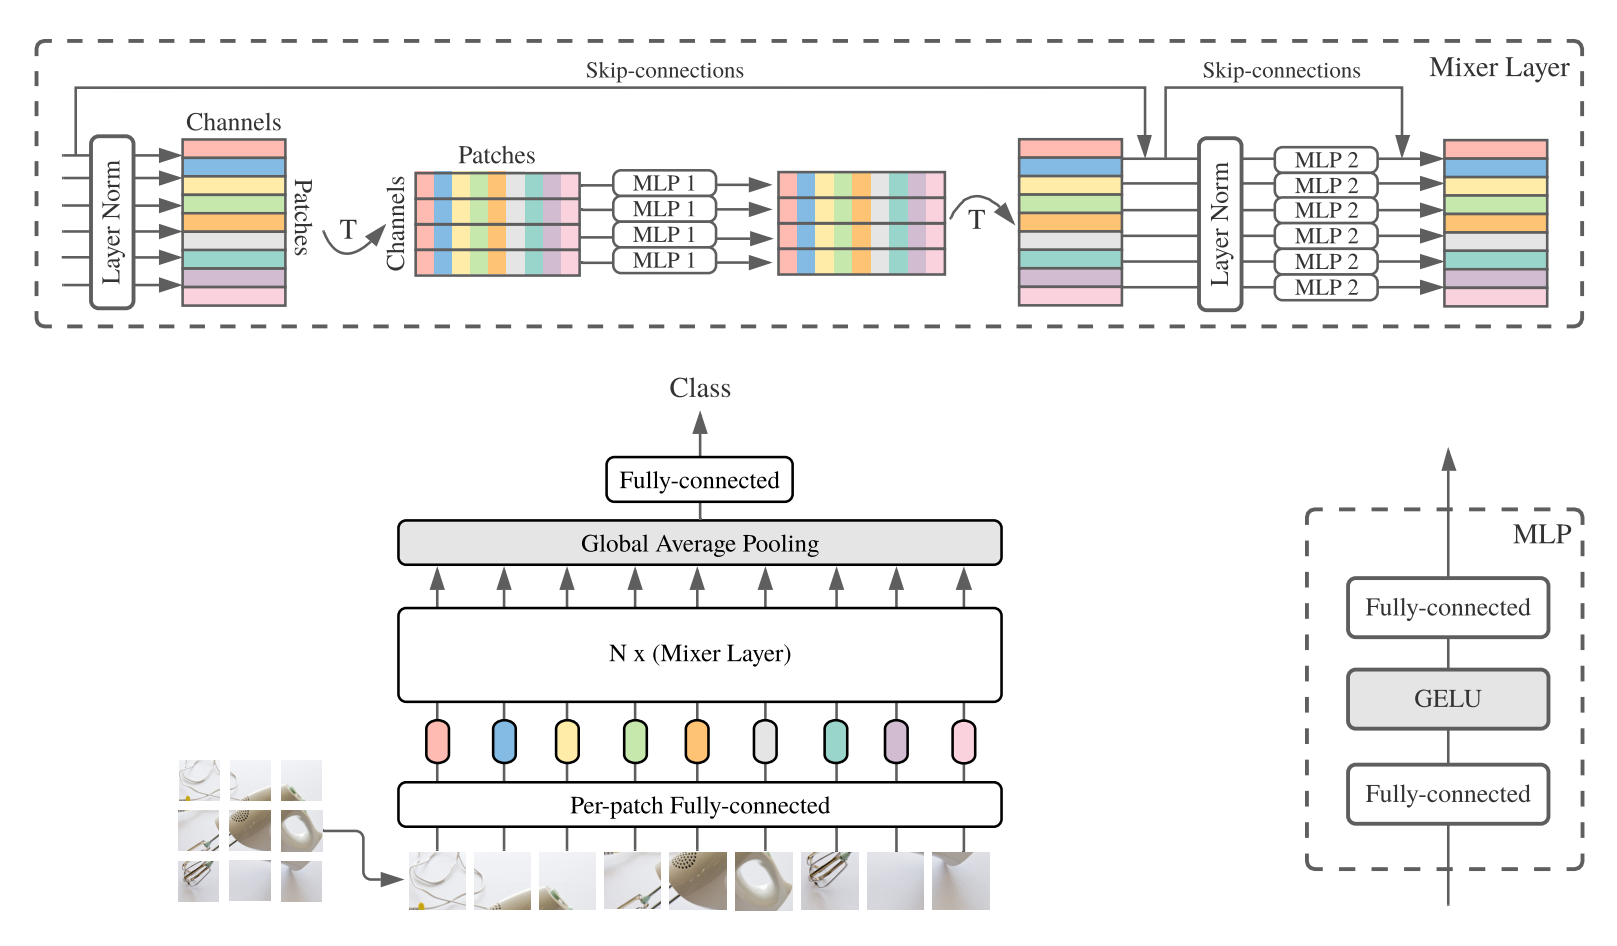

In [ ]:
def Patch_image(images, hidden_dim=256,patch_size=3,patch_method='extract'):
    if patch_method.lower() == 'conv':
        x = Conv2D(hidden_dim, patch_size, patch_size)(images)                                         # shape(B, 3, 3, 256)
        x = Reshape([-1, x.shape[-1]])(x)                             # shape(B, 9, 256)
    else:
        batch_size = tf.shape(images)[0]
        # patches = image_to_patches(x)
        patches = tf.image.extract_patches(images=images, sizes=[1, patch_size, patch_size, 1], 
                                            strides=[1, patch_size, patch_size, 1], rates=[1, 1, 1, 1], padding="VALID",)
        patch_dims = patches.shape[-1]
        x = Reshape([-1, patch_dims])(patches)               # shape = (B, 9, (3*3*372)) ---> (B, 9, 3348)
    return x

In [ ]:
def mlp_block(x, hidden_dim, dropout_ratio = 0.1):
    y = Dense(hidden_dim)(x)
    y = tf.nn.gelu(y)
    y = Dropout(dropout_ratio)(y)
    return Dense(x.shape[-1])(y)

# hidden_dim = mlp_dim = 128, 256

In [ ]:
def mixer_block(x, tokens_mlp_dim, channels_mlp_dim, dropout_ratio):
    y = LayerNormalization()(x)
    y = Permute((2, 1))(y)
    
    token_mixing = mlp_block(y, tokens_mlp_dim, dropout_ratio)
    token_mixing = Permute((2, 1))(token_mixing)
    x = Add()([x, token_mixing])
    
    y = LayerNormalization()(x)
    channel_mixing = mlp_block(y, channels_mlp_dim, dropout_ratio)
    output = Add()([x, channel_mixing])
    return output

In [ ]:
def mlp_mixer(x, num_layers, patch_size, hidden_dim, tokens_mlp_dim, channels_mlp_dim,
              num_classes = 7, dropout_rate = 0.0, patch_method = "extract"):
    # x = Patch_image(hidden_dim,patch_size,patch_method)(x)
    x = Patch_image(x, hidden_dim,patch_size,patch_method)

    # x = Reshape((x.shape[-3]*x.shape[-2], x.shape[-1]))(x)

    for _ in range(num_layers):
        x = mixer_block(x, tokens_mlp_dim, channels_mlp_dim, dropout_rate)
    
    x = LayerNormalization()(x)
    x = Dropout(0.25)(x)
    x = GlobalAveragePooling1D()(x)
    return Dense(num_classes, activation="softmax", dtype="float32")(x)

In [ ]:
def MLP_mixer_model(input_shape = (P_S, P_S, B), patch_size = 3, num_classes = 7, use_pearson_corr = False, num_layers = 4,
                    projection_dim = 256, tokens_mlp_dim = 128, channels_mlp_dim = 128, dropout_ratio = 0.0, patch_method='extract'):
    inputs = layers.Input(shape=input_shape)                                          # shape = (9,9,372)
    b = inputs.shape[0]
    if use_pearson_corr:
        x0 = Pearson_correlation_masked(P_S)(inputs)                                  # shape = (9,9,372)
    else:
        x0 = inputs
    x = mlp_mixer(x0, num_layers, patch_size, projection_dim, tokens_mlp_dim, channels_mlp_dim,
                  num_classes, dropout_ratio, patch_method=patch_method)
    model = Model(inputs = inputs, outputs = x, name = "MLP_Mixer")
    return model

In [ ]:
model = MLP_mixer_model((P_S, P_S, B), patch_size , num_classes, use_pearson_corr, num_layers,
                        projection_dim, tokens_mlp_dim, channels_mlp_dim, dropout_ratio, patch_method)

In [ ]:
model.summary()

Model: "MLP_Mixer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 9, 9, 372)]  0           []                               
                                                                                                  
 tf.image.extract_patches (TFOp  (None, 3, 3, 3348)  0           ['input_1[0][0]']                
 Lambda)                                                                                          
                                                                                                  
 reshape (Reshape)              (None, 9, 3348)      0           ['tf.image.extract_patches[0][0]'
                                                                 ]                                
                                                                                          

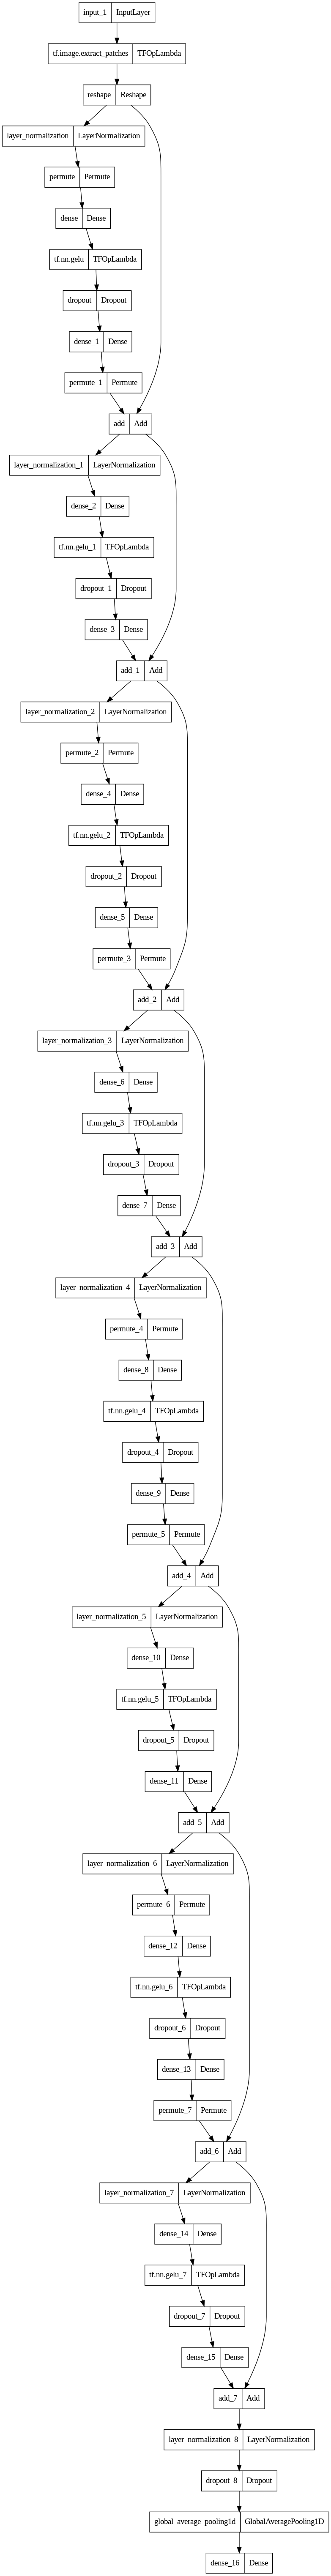

In [ ]:
plot_model(model)

Learning rate schedule: 0.0006 to 0.0006 to 1e-07


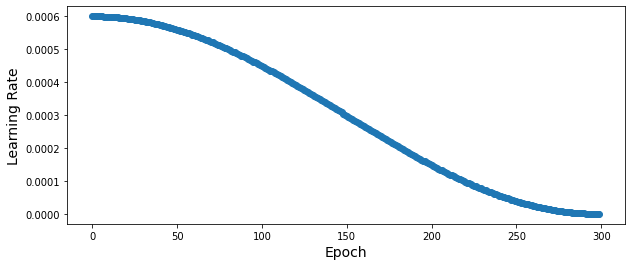

In [ ]:
LR_START = 3e-4
LR_MAX = 6e-4 
LR_MIN = 1e-7
LR_RAMPUP_EPOCHS = 0
LR_SUSTAIN_EPOCHS = 0
EPOCHS = epoch
STEPS = [epoch,epoch*2]

def lrfn(epoch):
    if epoch<STEPS[0]:
        epoch2 = epoch
        EPOCHS2 = STEPS[0]
    elif epoch<STEPS[0]+STEPS[1]:
        epoch2 = epoch-STEPS[0]
        EPOCHS2 = STEPS[1]
    elif epoch<STEPS[0]+STEPS[1]+STEPS[2]:
        epoch2 = epoch-STEPS[0]-STEPS[1]
        EPOCHS2 = STEPS[2]
    
    if epoch2 < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch2 + LR_START
    elif epoch2 < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        decay_total_epochs = EPOCHS2 - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS - 1
        decay_epoch_index = epoch2 - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS
        phase = math.pi * decay_epoch_index / decay_total_epochs
        cosine_decay = 0.5 * (1 + math.cos(phase))
        lr = (LR_MAX - LR_MIN) * cosine_decay + LR_MIN
    return lr

rng = [i for i in range(EPOCHS)]
lr_y = [lrfn(x) for x in rng]
plt.figure(figsize=(10, 4))
plt.plot(rng, lr_y, '-o')
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}". \
          format(lr_y[0], max(lr_y), lr_y[-1]))
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)
plt.xlabel('Epoch',size=14)
plt.ylabel('Learning Rate',size=14)
plt.show()

In [ ]:
filepath = folder_path +"Trained models/"+ str(train_percent)+"% ps_"+str(P_S)
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='max')
callbacks_list = [checkpoint, lr_callback]
model.compile(optimizer=optimizers.Adam(0.000003), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# history = model.fit(train_dataset, validation_data = (test_dataset), validation_freq = 1, batch_size = 32, callbacks=callbacks_list, shuffle = False, epochs=epochs)
start_time = time.time()
history = model.fit(x_train, y_train, validation_data = (x_test, y_test), validation_freq = 1, batch_size = BATCH_SIZE, callbacks=callbacks_list, shuffle = False, 
                    epochs=epoch, use_multiprocessing=True)
end_time = time.time()
tt = end_time - start_time
print("total training time: ", tt)


Epoch 1: LearningRateScheduler setting learning rate to 0.0006.
Epoch 1/300
46/46 [==============================] - ETA: 0s - loss: 1.2145 - accuracy: 0.5841
Epoch 1: val_accuracy improved from -inf to 0.73663, saving model to /content/drive/MyDrive/m_p/MLP/MLP-mixer/372 bands/Without Pearson correlation/Trained models/75% ps_9
46/46 [==============================] - 37s 456ms/step - loss: 1.2145 - accuracy: 0.5841 - val_loss: 0.6599 - val_accuracy: 0.7366 - lr: 6.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0005999834433585453.
Epoch 2/300
46/46 [==============================] - ETA: 0s - loss: 0.4241 - accuracy: 0.8411
Epoch 2: val_accuracy improved from 0.73663 to 0.89761, saving model to /content/drive/MyDrive/m_p/MLP/MLP-mixer/372 bands/Without Pearson correlation/Trained models/75% ps_9
46/46 [==============================] - 15s 341ms/step - loss: 0.4241 - accuracy: 0.8411 - val_loss: 0.2681 - val_accuracy: 0.8976 - lr: 5.9998e-04

Epoch 3: LearningRa

In [ ]:
Trainable_params = 0
for i in model.trainable_weights :
    Trainable_params+= np.prod(i.shape)

Non_trainable_params = 0
for i in model.non_trainable_weights:
    Non_trainable_params+= np.prod(i.shape)

Total_params = Trainable_params + Non_trainable_params
parameters_summary = [Total_params, Trainable_params, Non_trainable_params]

print("Total_params: ", Total_params)
print("Trainable_params: ", Trainable_params)
print("Non_trainable_params: ", Non_trainable_params)

Total_params:  1836525
Trainable_params:  1836525
Non_trainable_params:  0


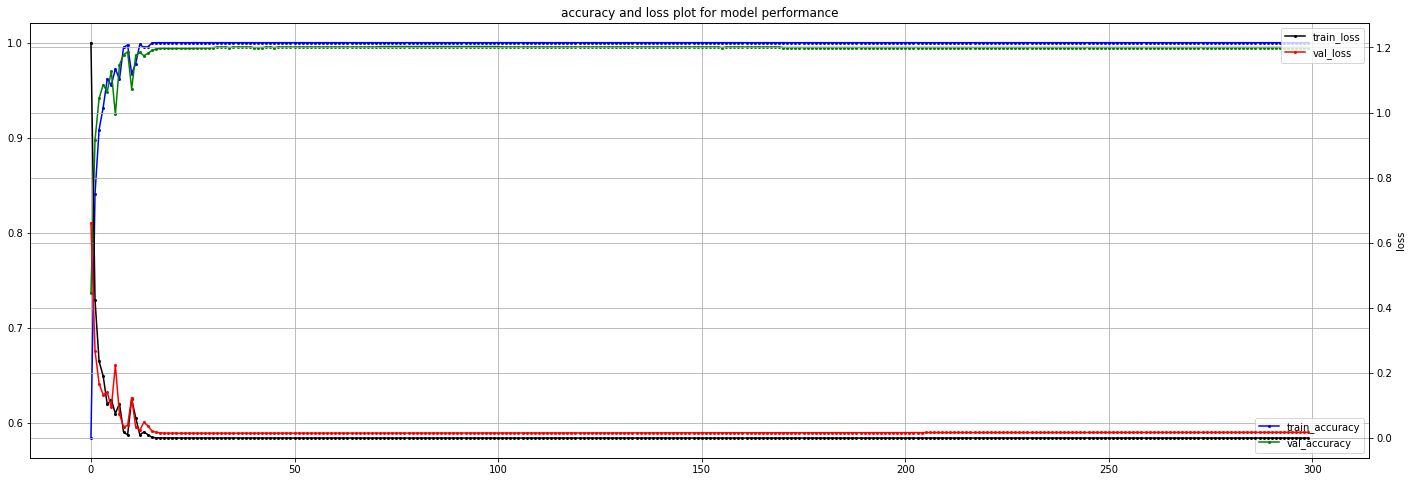

In [ ]:
plot_accuracy_loss_curve(history, use_pearson_corr = None, folder_path = None)

In [ ]:
y_pred = predict(model, x_test)

62/62 [==============================] - 3s 27ms/step


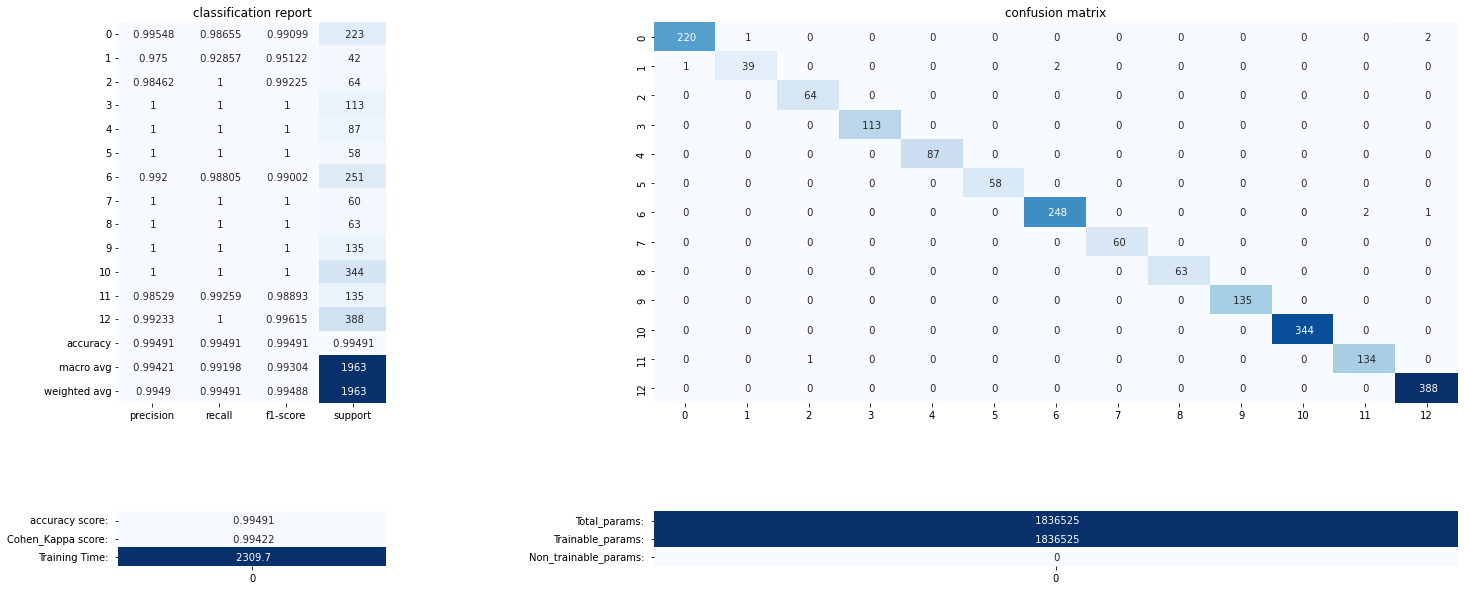

In [ ]:
performance_meausures(y_test, y_pred, tt, *parameters_summary, use_pearson_corr = None, folder_path = folder_path)

In [ ]:
for i in range(10):
    gc.collect()

In [ ]:
if use_pearson_corr:
    filepath1 = folder_path +"Results/ "+ str(train_percent)+"% performance.txt"
else:
    filepath1 = folder_path +"Results/"+ str(train_percent)+"% performance_ps_"+str(P_S)+".txt"
results = confusion_matrix(y_test,y_pred)
report = classification_report(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)
print(" ", file = open(filepath1, "a"))
print("P_S = ", P_S, file = open(filepath1, "a"))
print('Confusion Matrix :', file=open(filepath1,"a"))
print(results, file=open(filepath1,"a"))

print('Report : ', file=open(filepath1,"a"))
print(report, file=open(filepath1,"a"))

print('Accuracy Score :', accuracy, file=open(filepath1,"a")) 
print('Cohen_Kappa: ', kappa, file=open(filepath1,"a"))
print('Training Time:', tt, file=open(filepath1,"a"))

print("\033[1m", 'Confusion Matrix :', "\033[0m")
print(results) 
print("\033[1m", 'Report : ', "\033[0m")
print(report)
print("\033[1m", 'Accuracy Score :', "\033[0m", accuracy) 
print("\033[1m", 'Cohen_Kappa: ',  "\033[0m", kappa)
print("\033[1m", 'Training Time:', "\033[0m", tt)
print("\033[1m", "Total_params: ", "\033[0m", Total_params)
print("\033[1m", "Trainable_params: ", "\033[0m", Trainable_params)
print("\033[1m", "Non_trainable_params: ", "\033[0m", Non_trainable_params)

 Confusion Matrix : 
[[220   1   0   0   0   0   0   0   0   0   0   0   2]
 [  1  39   0   0   0   0   2   0   0   0   0   0   0]
 [  0   0  64   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0 113   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  87   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0  58   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 248   0   0   0   0   2   1]
 [  0   0   0   0   0   0   0  60   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0  63   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0 135   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 344   0   0]
 [  0   0   1   0   0   0   0   0   0   0   0 134   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0 388]]
 Report :  
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       223
           1       0.97      0.93      0.95        42
           2       0.98      1.00      0.99        64
           3       1.00      1.00 

In [ ]:
y_test = y_test.reshape(y_test.shape[0],1)
y_pred = y_pred.reshape(y_pred.shape[0],1)
y_pred = y_pred.astype(int)
y_combined = np.concatenate((y_test,y_pred),axis=1)
if use_pearson_corr:
    img_path = folder_path +"Results/with_corr_"+str(train_percent)+"%_mlp_mixer372_ps"+str(P_S)+".csv"
else:
    img_path = folder_path + "Results/without_corr_"+ str(train_percent) + "%_mlp_mixer372_ps_" +str(P_S) + ".csv"
 #filepath_1 = "/content/drive/My Drive/m_p/CNN Models Comparitive Study/372 band/Simple Models/Results/
np.savetxt(img_path, y_combined, delimiter=",")

In [ ]:
y_hat = predict_image(model, padded_x, H, W, B, P_S)

In [ ]:
y_hat = y_hat.reshape((H,W))
a_c = np.unique(y_hat,return_counts=True)
print(a_c)
print(a_c,file=open(filepath1,"a"))

(array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.]), array([ 75741,   6913,   6225,  28232,   9848,  39679,  34076,  21403,
        15952,  31875, 139826,  59647, 153749]))


In [ ]:
y_hat = y_hat.reshape((H,W))

In [ ]:
img_path = folder_path + "Results/" + str(train_percent) + "% ps_" +str(P_S) + " predicted_image" + ".png"
spectral.save_rgb(img_path, y_hat, colors = spectral.spy_colors)
spectral.save_rgb("available_image.png", y, colors = spectral.spy_colors)

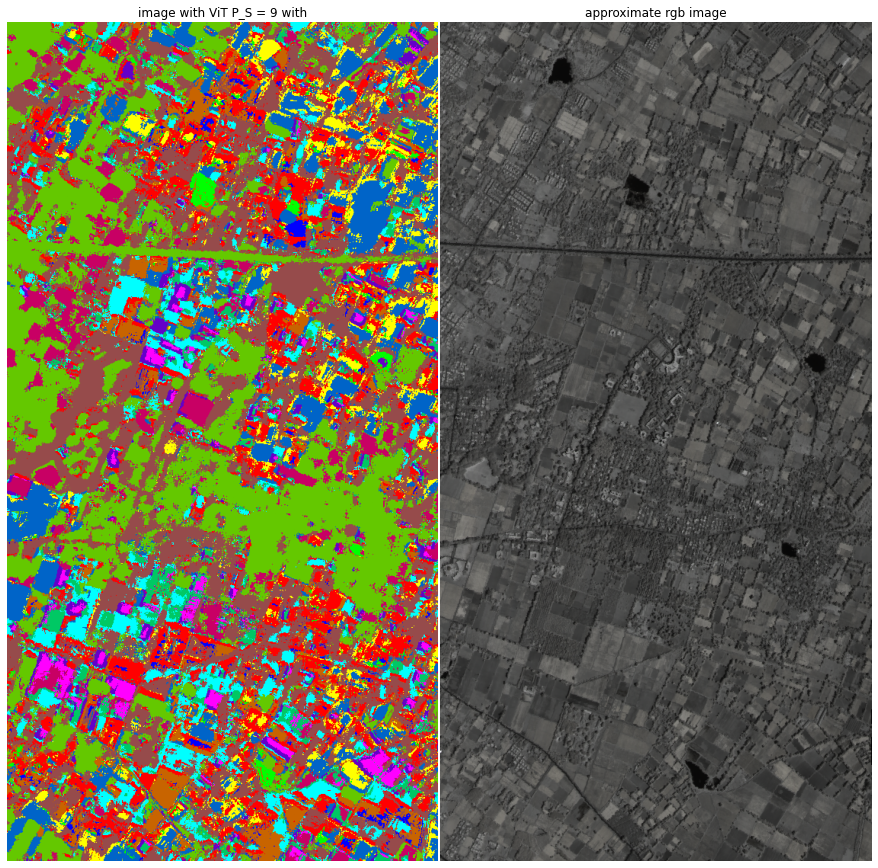

In [ ]:
# img_path = folder_path + "Results/" + str(train_percent) + "% ps_" +str(P_S) + " predicted_image with" + str(method) + ".png"
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize = (12, 12))
img = plt.imread(img_path)
ax1.imshow(plt.imread(img_path))
ax1.set_title("image with ViT P_S = 9 with")
ax1.axis("off")

# ax2.imshow(plt.imread(folder_path + "Results/" + str(train_percent) + "% ps_" +str(P_S) + " predicted_image_temp.png"))
# ax2.set_title("old predicted image")
# ax2.axis("off")

ax2.imshow(plt.imread("/content/drive/MyDrive/m_p/data/372 band/Approximate RGB Image.png"))
ax2.set_title("approximate rgb image")
ax2.axis("off")

plt.tight_layout(pad = 0, h_pad=0, w_pad=0.2)
plt.show()